<a href="https://colab.research.google.com/github/Rahulgarg95/pytorch_jovian/blob/main/02_insurance_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1MY0TfaPQTk7nykEmcytWFgCiA1DtiF43')

     |████████████████████████████████| 71kB 5.4MB/s 


# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [2]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [3]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [5]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [6]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [7]:
your_name = 'Rahul' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [8]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [9]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
457,57,female,29.58015,0,no,12314.406052
1050,44,female,35.84635,1,no,8344.060868
56,58,female,30.87025,2,no,14151.663500
311,19,female,23.95900,0,no,1806.871040
1288,20,male,38.21800,2,yes,39878.348640


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [10]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [11]:
num_cols = dataframe.shape[1]
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [12]:
input_cols = dataframe.columns.to_list()

In [13]:
input_cols.remove('charges')

In [14]:
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

In [15]:
dataframe.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
charges     float64
dtype: object

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [16]:
categorical_cols = ['smoker','sex']

**Q: What are the column titles of output/target variable(s)?**

In [17]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

Min Charges:  1166.7488560000002
Max Charges:  66321.2451304
Mean Charges:  13645.824006566623


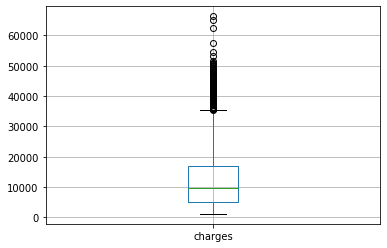

In [18]:
# Write your answer here
print('Min Charges: ',dataframe['charges'].min())
print('Max Charges: ',dataframe['charges'].max())
print('Mean Charges: ',dataframe['charges'].mean())
dataframe.boxplot('charges')

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [ ]:
!pip install jovian --upgrade -q

In [ ]:
import jovian

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/02-insurance-linear-regression


'https://jovian.ai/rahulgarg95/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [19]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [21]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
print(inputs_array.shape,targets_array.shape)
inputs_array, targets_array

(1271, 5) (1271, 1)


(array([[57.     ,  0.     , 29.58015,  0.     ,  0.     ],
        [44.     ,  0.     , 35.84635,  1.     ,  0.     ],
        [58.     ,  0.     , 30.87025,  2.     ,  0.     ],
        ...,
        [59.     ,  0.     , 33.756  ,  2.     ,  0.     ],
        [41.     ,  1.     , 27.936  ,  1.     ,  0.     ],
        [36.     ,  0.     , 29.1194 ,  0.     ,  0.     ]]),
 array([[12314.406052 ],
        [ 8344.060868 ],
        [14151.6635   ],
        ...,
        [38387.0323512],
        [ 6533.5244   ],
        [ 5483.062832 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [22]:
inputs = torch.from_numpy(inputs_array.astype('float32'))
targets = torch.from_numpy(targets_array.astype('float32'))

In [23]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [24]:
dataset = TensorDataset(inputs, targets)

In [25]:
dataset[:]

(tensor([[57.0000,  0.0000, 29.5802,  0.0000,  0.0000],
         [44.0000,  0.0000, 35.8464,  1.0000,  0.0000],
         [58.0000,  0.0000, 30.8703,  2.0000,  0.0000],
         ...,
         [59.0000,  0.0000, 33.7560,  2.0000,  0.0000],
         [41.0000,  1.0000, 27.9360,  1.0000,  0.0000],
         [36.0000,  0.0000, 29.1194,  0.0000,  0.0000]]), tensor([[12314.4062],
         [ 8344.0605],
         [14151.6631],
         ...,
         [38387.0312],
         [ 6533.5244],
         [ 5483.0630]]))

In [27]:
dataset[1]

(tensor([44.0000,  0.0000, 35.8464,  1.0000,  0.0000]), tensor([8344.0605]))

In [26]:
dataset[0]

(tensor([57.0000,  0.0000, 29.5802,  0.0000,  0.0000]), tensor([12314.4062]))

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [28]:
val_percent = 0.12 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
print(train_size,val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

1119 152


Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [29]:
batch_size = 128

In [30]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [31]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[50.0000,  0.0000, 27.3152,  3.0000,  0.0000],
        [62.0000,  0.0000, 30.7781,  0.0000,  0.0000],
        [46.0000,  0.0000, 34.4641,  0.0000,  1.0000],
        [18.0000,  1.0000, 22.3003,  0.0000,  0.0000],
        [39.0000,  1.0000, 34.2410,  2.0000,  1.0000],
        [61.0000,  1.0000, 34.7842,  0.0000,  1.0000],
        [41.0000,  0.0000, 30.6859,  1.0000,  0.0000],
        [23.0000,  0.0000, 27.4607,  0.0000,  1.0000],
        [26.0000,  1.0000, 31.5153,  1.0000,  0.0000],
        [34.0000,  1.0000, 26.1900,  2.0000,  0.0000],
        [50.0000,  0.0000, 26.2628,  1.0000,  0.0000],
        [51.0000,  1.0000, 22.5137,  1.0000,  1.0000],
        [58.0000,  0.0000, 31.4231,  1.0000,  0.0000],
        [63.0000,  0.0000, 35.2110,  0.0000,  0.0000],
        [56.0000,  0.0000, 31.3310,  3.0000,  0.0000],
        [60.0000,  1.0000, 32.1167,  3.0000,  0.0000],
        [36.0000,  0.0000, 21.9220,  2.0000,  1.0000],
        [31.0000,  0.0000, 25.8214,  0.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/02-insurance-linear-regression


'https://jovian.ai/rahulgarg95/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [32]:
input_size = len(input_cols)
output_size = len(output_cols)

In [33]:
print(input_size,output_size)

5 1


**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [34]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out,targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [74]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [75]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2803,  0.0168, -0.0196,  0.3051, -0.2850]], requires_grad=True),
 Parameter containing:
 tensor([0.1238], requires_grad=True)]

One final commit before we train the model.

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/02-insurance-linear-regression


'https://jovian.ai/rahulgarg95/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [76]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [77]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13582.3525390625}


In [78]:
#model = InsuranceModel()


We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [79]:
epochs = 10000
lr = 1e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7241.5835
Epoch [40], val_loss: 7011.8936
Epoch [60], val_loss: 6841.7349
Epoch [80], val_loss: 6741.4316
Epoch [100], val_loss: 6697.5366
Epoch [120], val_loss: 6679.2715
Epoch [140], val_loss: 6673.2173
Epoch [160], val_loss: 6668.1572
Epoch [180], val_loss: 6665.0630
Epoch [200], val_loss: 6663.3784
Epoch [220], val_loss: 6660.8857
Epoch [240], val_loss: 6655.8359
Epoch [260], val_loss: 6653.2427
Epoch [280], val_loss: 6653.8818
Epoch [300], val_loss: 6649.1440
Epoch [320], val_loss: 6647.1606
Epoch [340], val_loss: 6647.2363
Epoch [360], val_loss: 6643.1147
Epoch [380], val_loss: 6641.7676
Epoch [400], val_loss: 6640.1528
Epoch [420], val_loss: 6638.6611
Epoch [440], val_loss: 6636.8237
Epoch [460], val_loss: 6635.3652
Epoch [480], val_loss: 6632.6680
Epoch [500], val_loss: 6631.6826
Epoch [520], val_loss: 6629.7197
Epoch [540], val_loss: 6627.9678
Epoch [560], val_loss: 6627.1650
Epoch [580], val_loss: 6625.0269
Epoch [600], val_loss: 6622.6074
Epoch [620], v

In [80]:
epochs = 2000
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6155.5283
Epoch [40], val_loss: 6155.4683
Epoch [60], val_loss: 6155.3359
Epoch [80], val_loss: 6155.2764
Epoch [100], val_loss: 6155.2773
Epoch [120], val_loss: 6155.2974
Epoch [140], val_loss: 6155.0239
Epoch [160], val_loss: 6154.8574
Epoch [180], val_loss: 6154.8018
Epoch [200], val_loss: 6154.6680
Epoch [220], val_loss: 6154.7930
Epoch [240], val_loss: 6154.6660
Epoch [260], val_loss: 6154.4697
Epoch [280], val_loss: 6154.5000
Epoch [300], val_loss: 6154.4473
Epoch [320], val_loss: 6154.2852
Epoch [340], val_loss: 6154.3188
Epoch [360], val_loss: 6154.1416
Epoch [380], val_loss: 6153.9922
Epoch [400], val_loss: 6153.9624
Epoch [420], val_loss: 6153.8760
Epoch [440], val_loss: 6153.5615
Epoch [460], val_loss: 6153.6641
Epoch [480], val_loss: 6153.4404
Epoch [500], val_loss: 6153.4482
Epoch [520], val_loss: 6153.4697
Epoch [540], val_loss: 6153.3872
Epoch [560], val_loss: 6153.1377
Epoch [580], val_loss: 6153.1738
Epoch [600], val_loss: 6153.0522
Epoch [620], v

In [81]:
epochs = 15000
lr = 1e-3
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6147.0459
Epoch [40], val_loss: 6147.0332
Epoch [60], val_loss: 6147.0298
Epoch [80], val_loss: 6147.0376
Epoch [100], val_loss: 6147.0078
Epoch [120], val_loss: 6147.0015
Epoch [140], val_loss: 6146.9844
Epoch [160], val_loss: 6146.9639
Epoch [180], val_loss: 6146.9629
Epoch [200], val_loss: 6146.9634
Epoch [220], val_loss: 6146.9780
Epoch [240], val_loss: 6146.9521
Epoch [260], val_loss: 6146.9512
Epoch [280], val_loss: 6146.9355
Epoch [300], val_loss: 6146.9238
Epoch [320], val_loss: 6146.9043
Epoch [340], val_loss: 6146.9077
Epoch [360], val_loss: 6146.8940
Epoch [380], val_loss: 6146.8867
Epoch [400], val_loss: 6146.8965
Epoch [420], val_loss: 6146.8691
Epoch [440], val_loss: 6146.8496
Epoch [460], val_loss: 6146.8613
Epoch [480], val_loss: 6146.8408
Epoch [500], val_loss: 6146.8418
Epoch [520], val_loss: 6146.8540
Epoch [540], val_loss: 6146.8262
Epoch [560], val_loss: 6146.7988
Epoch [580], val_loss: 6146.7979
Epoch [600], val_loss: 6146.7715
Epoch [620], v

In [82]:
epochs = 15000
lr = 1e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [4760], val_loss: 6120.6328
Epoch [4780], val_loss: 6120.7114
Epoch [4800], val_loss: 6120.7373
Epoch [4820], val_loss: 6120.5439
Epoch [4840], val_loss: 6120.5752
Epoch [4860], val_loss: 6120.4043
Epoch [4880], val_loss: 6120.2681
Epoch [4900], val_loss: 6120.2539
Epoch [4920], val_loss: 6120.2051
Epoch [4940], val_loss: 6120.0957
Epoch [4960], val_loss: 6120.0264
Epoch [4980], val_loss: 6120.0098
Epoch [5000], val_loss: 6119.8477
Epoch [5020], val_loss: 6119.6357
Epoch [5040], val_loss: 6119.5830
Epoch [5060], val_loss: 6119.5396
Epoch [5080], val_loss: 6119.5273
Epoch [5100], val_loss: 6119.3159
Epoch [5120], val_loss: 6119.3159
Epoch [5140], val_loss: 6119.0669
Epoch [5160], val_loss: 6119.1426
Epoch [5180], val_loss: 6119.0391
Epoch [5200], val_loss: 6118.9736
Epoch [5220], val_loss: 6118.9189
Epoch [5240], val_loss: 6118.8716
Epoch [5260], val_loss: 6118.6758
Epoch [5280], val_loss: 6118.6621
Epoch [5300], val_loss: 6118.5254
Epoch [5320], val_loss: 6118.5229
Epoch [5340], 

In [83]:
epochs = 10000
lr = 1e-1
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6077.2529
Epoch [40], val_loss: 6079.9248
Epoch [60], val_loss: 6074.3047
Epoch [80], val_loss: 6076.2144
Epoch [100], val_loss: 6074.0576
Epoch [120], val_loss: 6073.5137
Epoch [140], val_loss: 6070.6621
Epoch [160], val_loss: 6072.7012
Epoch [180], val_loss: 6069.3364
Epoch [200], val_loss: 6072.1021
Epoch [220], val_loss: 6069.4883
Epoch [240], val_loss: 6068.7051
Epoch [260], val_loss: 6066.1836
Epoch [280], val_loss: 6069.3965
Epoch [300], val_loss: 6066.2803
Epoch [320], val_loss: 6064.1519
Epoch [340], val_loss: 6066.7100
Epoch [360], val_loss: 6062.8687
Epoch [380], val_loss: 6062.4043
Epoch [400], val_loss: 6062.5635
Epoch [420], val_loss: 6061.0142
Epoch [440], val_loss: 6059.1719
Epoch [460], val_loss: 6057.2383
Epoch [480], val_loss: 6058.9893
Epoch [500], val_loss: 6055.6465
Epoch [520], val_loss: 6056.9053
Epoch [540], val_loss: 6058.1641
Epoch [560], val_loss: 6055.4424
Epoch [580], val_loss: 6054.1211
Epoch [600], val_loss: 6055.2314
Epoch [620], v

In [84]:
epochs = 5000
lr = 1e-1
history6 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5680.2080
Epoch [40], val_loss: 5679.6704
Epoch [60], val_loss: 5676.8994
Epoch [80], val_loss: 5679.3623
Epoch [100], val_loss: 5676.4155
Epoch [120], val_loss: 5676.3320
Epoch [140], val_loss: 5676.6499
Epoch [160], val_loss: 5673.9424
Epoch [180], val_loss: 5673.3838
Epoch [200], val_loss: 5672.3125
Epoch [220], val_loss: 5671.3730
Epoch [240], val_loss: 5669.2988
Epoch [260], val_loss: 5670.2744
Epoch [280], val_loss: 5668.5273
Epoch [300], val_loss: 5667.5518
Epoch [320], val_loss: 5669.3770
Epoch [340], val_loss: 5666.6113
Epoch [360], val_loss: 5665.4619
Epoch [380], val_loss: 5666.9189
Epoch [400], val_loss: 5663.6670
Epoch [420], val_loss: 5663.9082
Epoch [440], val_loss: 5661.5537
Epoch [460], val_loss: 5659.6167
Epoch [480], val_loss: 5662.1157
Epoch [500], val_loss: 5658.5132
Epoch [520], val_loss: 5658.7788
Epoch [540], val_loss: 5659.3848
Epoch [560], val_loss: 5657.9014
Epoch [580], val_loss: 5656.3369
Epoch [600], val_loss: 5655.0825
Epoch [620], v

In [85]:
epochs = 10000
lr = 1e-1
history7 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5485.3838
Epoch [40], val_loss: 5483.7744
Epoch [60], val_loss: 5482.2051
Epoch [80], val_loss: 5483.1182
Epoch [100], val_loss: 5482.3867
Epoch [120], val_loss: 5483.1650
Epoch [140], val_loss: 5481.1938
Epoch [160], val_loss: 5480.6660
Epoch [180], val_loss: 5479.9390
Epoch [200], val_loss: 5478.7837
Epoch [220], val_loss: 5477.2598
Epoch [240], val_loss: 5478.3657
Epoch [260], val_loss: 5476.3623
Epoch [280], val_loss: 5476.7500
Epoch [300], val_loss: 5475.6616
Epoch [320], val_loss: 5477.2217
Epoch [340], val_loss: 5472.3296
Epoch [360], val_loss: 5473.0420
Epoch [380], val_loss: 5471.8130
Epoch [400], val_loss: 5472.7139
Epoch [420], val_loss: 5469.8477
Epoch [440], val_loss: 5469.6152
Epoch [460], val_loss: 5468.4580
Epoch [480], val_loss: 5467.7217
Epoch [500], val_loss: 5469.6753
Epoch [520], val_loss: 5466.4932
Epoch [540], val_loss: 5463.7461
Epoch [560], val_loss: 5464.9277
Epoch [580], val_loss: 5464.1914
Epoch [600], val_loss: 5463.1162
Epoch [620], v

In [94]:
epochs = 30000
lr = 1e-1
history7 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5104.0537
Epoch [40], val_loss: 5103.3311
Epoch [60], val_loss: 5102.5220
Epoch [80], val_loss: 5100.1860
Epoch [100], val_loss: 5099.6875
Epoch [120], val_loss: 5100.8096
Epoch [140], val_loss: 5097.5537
Epoch [160], val_loss: 5097.7344
Epoch [180], val_loss: 5098.1274
Epoch [200], val_loss: 5099.5137
Epoch [220], val_loss: 5097.1934
Epoch [240], val_loss: 5095.9209
Epoch [260], val_loss: 5095.1387
Epoch [280], val_loss: 5092.2061
Epoch [300], val_loss: 5092.2520
Epoch [320], val_loss: 5092.8281
Epoch [340], val_loss: 5094.2612
Epoch [360], val_loss: 5093.8130
Epoch [380], val_loss: 5087.6660
Epoch [400], val_loss: 5087.0664
Epoch [420], val_loss: 5088.0898
Epoch [440], val_loss: 5086.9844
Epoch [460], val_loss: 5089.1748
Epoch [480], val_loss: 5084.2031
Epoch [500], val_loss: 5086.3203
Epoch [520], val_loss: 5082.1919
Epoch [540], val_loss: 5083.0938
Epoch [560], val_loss: 5081.9214
Epoch [580], val_loss: 5080.6641
Epoch [600], val_loss: 5080.9551
Epoch [620], v

In [107]:
epochs = 5000
lr = 1e-2
history8 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3438.9858
Epoch [40], val_loss: 3435.0146
Epoch [60], val_loss: 3430.5620
Epoch [80], val_loss: 3427.0151
Epoch [100], val_loss: 3424.1660
Epoch [120], val_loss: 3422.4365
Epoch [140], val_loss: 3420.5654
Epoch [160], val_loss: 3419.3848
Epoch [180], val_loss: 3418.2139
Epoch [200], val_loss: 3417.3652
Epoch [220], val_loss: 3416.3181
Epoch [240], val_loss: 3416.0620
Epoch [260], val_loss: 3415.6311
Epoch [280], val_loss: 3415.4976
Epoch [300], val_loss: 3415.3643
Epoch [320], val_loss: 3414.7803
Epoch [340], val_loss: 3414.8164
Epoch [360], val_loss: 3414.7280
Epoch [380], val_loss: 3414.5483
Epoch [400], val_loss: 3414.4150
Epoch [420], val_loss: 3414.4229
Epoch [440], val_loss: 3414.2478
Epoch [460], val_loss: 3413.9963
Epoch [480], val_loss: 3414.1157
Epoch [500], val_loss: 3414.1614
Epoch [520], val_loss: 3413.9644
Epoch [540], val_loss: 3413.9714
Epoch [560], val_loss: 3414.1357
Epoch [580], val_loss: 3413.9819
Epoch [600], val_loss: 3413.8232
Epoch [620], v

**Q: What is the final validation loss of your model?**

In [108]:
val_loss = evaluate(model, val_loader)

In [109]:
print(val_loss)

{'val_loss': 3413.51123046875}


Let's log the final validation loss to Jovian and commit the notebook

In [110]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [111]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/rahulgarg95/02-insurance-linear-regression


'https://jovian.ai/rahulgarg95/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [112]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [113]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([36.0000,  0.0000, 29.0224,  0.0000,  0.0000])
Target: tensor([5084.5981])
Prediction: tensor([6188.5190])


In [114]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([50.0000,  0.0000, 26.9951,  3.0000,  0.0000])
Target: tensor([20539.3594])
Prediction: tensor([11202.9199])


In [115]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([58.0000,  1.0000, 27.7372,  0.0000,  0.0000])
Target: tensor([12205.3145])
Prediction: tensor([11864.7969])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes